In [2]:
import pandas as pd
import matplotlib

In [3]:
# Get tree measurements for year 82, 85, and 90
treeMeasurements = pd.read_csv("C55_TreeMeasurements.csv")

#getting trees from 1982 and 1985 measurements
desiredCols1 = ["PLOT", "TREE", "RECRUIT", "SPECIES", "D82", "D85"]
customMeasurements1 = treeMeasurements[desiredCols1]

#getting trees from 1985 to 1990
desiredCols2 = ["PLOT", "TREE", "RECRUIT", "SPECIES", "D85", "D90"]
customMeasurements2 = treeMeasurements[desiredCols2]

#cleaning data to gather trees that only have measurements at both ends of the period
clean82_85 = customMeasurements1.dropna()
clean85_90 = customMeasurements2.dropna()


In [4]:
# getting foliar nutrients from csv file
foliarNutrients = pd.read_csv("C55_FoliarNutrients.csv")
foliarNutrients = foliarNutrients.drop("REPLICATE", axis=1)

# Get foliar nutrient levels 1982
foliarNutrients82 = foliarNutrients.loc[foliarNutrients['YEAR'] == 1982]

# Get foliar nutrient levels 1985
foliarNutrients85 = foliarNutrients.loc[foliarNutrients['YEAR'] == 1985]

In [5]:
# Add foliar nutrients to tree data 
allTreeData82_85 = pd.merge(clean82_85, foliarNutrients82, on="PLOT", how="outer")

allTreeData85_90 = pd.merge(clean85_90, foliarNutrients85, on="PLOT", how="outer")


In [6]:
# Getting percent growth for each tree per year
# perc_growth = (D85-D82)/D82
allTreeData82_85["Growth"] = (allTreeData82_85["D85"]-allTreeData82_85["D82"])/allTreeData82_85["D82"]
# growth_per_yr = prec_growth/85-82
allTreeData82_85["Growth/yr"] = allTreeData82_85["Growth"]/3


#getting percent growth for 1985-1990
# perc_growth = (D90-D85)/D825
allTreeData85_90["Growth"] = (allTreeData85_90["D90"]-allTreeData85_90["D85"])/allTreeData85_90["D85"]
# growth_per_yr = prec_growth/85-82
allTreeData85_90["Growth/yr"] = allTreeData85_90["Growth"]/5



allTreeData = pd.concat([allTreeData82_85, allTreeData85_90], ignore_index=True)


In [27]:
# Extract relevant columns: 
relColumns = ["SPECIES", "TOTN", "TOTP", "TOTK", "TOTS", "TOTCa", "Growth/yr"]
modelingData82 = allTreeData82_85[relColumns]
modelingData85 = allTreeData85_90[relColumns]

# combine dataframes
modelingData = pd.concat([modelingData82, modelingData85], ignore_index=True)
modelingData['id'] = modelingData.index

<AxesSubplot:xlabel='bins'>

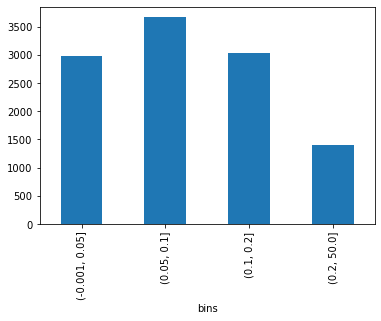

In [28]:
bins = [0, .05, .1, .2, 50]
modelingCopy = modelingData
modelingCopy['bins'] = pd.cut(modelingData['Growth/yr'], bins = bins, include_lowest=True)
plotDF = modelingCopy.groupby('bins').bins.count()
plotDF.plot(kind="bar")
# Histogram for percent growth per year


In [29]:
# Getting Columns for neural network classification
# What bin does the growth/yr fall into? that bin gets a 1, others get 0

mergeDF = pd.DataFrame(columns=['id', 'bin'])

# For each row in modelingData
for index, row in modelingData.iterrows():
    if row['Growth/yr'] <= .05:
        mergeDF.loc[index] = pd.Series({'id': index, 'bin': 0})
    elif row['Growth/yr'] <= .1:
        mergeDF.loc[index] = pd.Series({'id': index, 'bin': 1})
    elif row['Growth/yr'] <= .2:
        mergeDF.loc[index] = pd.Series({'id': index, 'bin': 2})
    else:
        mergeDF.loc[index] = pd.Series({'id': index, 'bin': 3})

modelingData = pd.merge(modelingData, mergeDF, on='id', how="outer")

In [40]:
# input variables: SPECIES, TOTN, TOTP, TOTK, TOTS, TOTCa, and TOTMg (not used)
# label: fixed bins (1 for correct bin, 0 for all others)
classifyColumns = ['SPECIES', 'TOTN', 'TOTP', 'TOTK', 'TOTS', 'TOTCa', 'bin']
classifyData = modelingData[classifyColumns]
classifyX = classifyData.iloc[:,:6].values
classifyY = classifyData.iloc[:,6:7].values

In [41]:
#Classification Neural Network train/test data
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
classifyY = ohe.fit_transform(classifyY).toarray()

from sklearn.model_selection import train_test_split
classifyX_train, classifyX_test, classifyY_train, classifyY_test = train_test_split(classifyX, classifyY, test_size = 0.1)

In [42]:
#Building Neural Network for Classification
import keras
from keras.models import Sequential
from keras.layers import Dense

classifyModel = Sequential()
classifyModel.add(Dense(4, input_dim=6, activation='relu'))
#classifyModel.add(Dense(4, activation=''))

classifyModel.compile(loss='categorical_crossentropy', metrics=['accuracy'])

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#Training classification model
training = classifyModel.fit(classifyX_train, classifyY_train, epochs=100, batch_size=64)

In [ ]:
#Testing classification model


In [ ]:
# Getting Columns for neural network regression
# input variables: SPECIES, TOTN, TOTP, TOTK, TOTS, TOTCa, and TOTMg (not used)
# label: predicting growth per year